In [1]:
## Along slope velocity field

In [1]:
import os

In [2]:
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
from xgcm import Grid
import glob

In [3]:
import matplotlib.dates as mdates
import datetime
import pandas as pd

In [4]:
%matplotlib inline

In [5]:
from matplotlib import rc
rc('font', **{'size':40})
rc('text', usetex=False)
rc('xtick', labelsize=40) #20 
rc('ytick', labelsize=40) #20
rc('axes', titlesize=40)    # fontsize of the axes title
rc('axes', labelsize=40) #24    # fontsize of the x and y labels

In [6]:
session=cc.database.create_session()

exp_ctrl= '01deg_jra55v13_ryf9091'
exp_wthmp= '01deg_jra55v13_ryf9091_qian_wthmp'
exp_wthp= '01deg_jra55v13_ryf9091_qian_wthp'
lat_lim = slice(-79, -60)
lon_lim = slice(-279.99,80)

#### SET EXPT HERE
expt = exp_ctrl


In [7]:
# We will use an annual average from 10 year in the RYF run
start_time_mw='2110-01-31 00:00:00' 
end_time_mw='2159-12-31 00:00:00'
start_time='1950-01-31 00:00:00'
end_time='1959-12-31 00:00:00'


In [8]:
from dask.distributed import Client

c=Client(local_directory = '/g/data/v45/qo9901/') 
c 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36811/status,
Dashboard: /proxy/36811/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37485,Workers: 2
Dashboard: /proxy/36811/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:39223,Total threads: 1
Dashboard: /proxy/39375/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45077,


In [12]:
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

walltime = '01:00:00'
cores = 28
memory = '252GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P v45','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/e14+gdata/hh5+gdata/v45+gdata/cj50',
                                '-l jobfs=400GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     #python=os.environ["DASK_PYTHON"]
                    )
cluster

# and if you want even more power, you can use this to make it three nodes
cluster.scale(jobs=3)

# then, run this to make a dask client

c = Client(cluster)
c

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/45909/status,
Dashboard: /proxy/45909/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.27:46021,Workers: 0
Dashboard: /proxy/45909/status,Total threads: 0
Started: Just now,Total memory: 0 B


Task exception was never retrieved
future: <Task finished name='Task-607194' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-607195' coro=<Client._gather.<locals>.wait() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:2197> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py", line 2206, in wait
    raise AllExit()
distributed.client.AllExit


In [9]:
flex_period = slice(start_time_mw,end_time_mw)
flex_period = slice('2110','2159')

In [25]:
ee = cc.explore.ExperimentExplorer(session=session, experiment=expt)
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [10]:
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(yu_ocean = slice(-79,-60))
hu

<xarray.DataArray 'hu' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<getitem, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [11]:
# NEEDload coordinates and grid specifications
geolat_t = cc.querying.getvar(expt, 'geolat_t', session=session, n=1)
geolon_t = cc.querying.getvar(expt, 'geolon_t', session=session, n=1)

dxt = cc.querying.getvar(expt=expt, variable='dxt', session=session, frequency='static', n=1)
dyt = cc.querying.getvar(expt=expt, variable='dyt', session=session, frequency='static', n=1)

dxu = cc.querying.getvar(expt=expt, variable='dxu', session=session, frequency='static', n=1)
dyu = cc.querying.getvar(expt=expt, variable='dyu', session=session, frequency='static', n=1)

In [12]:
flex_period

slice('2110', '2159', None)

In [13]:
#sea_level_lim = sea_level.sel( xt_ocean= lon_lim, yt_ocean=lat_lim, time = flex_period)

# coordinates
lat_t = geolat_t.sel( xt_ocean= lon_lim,yt_ocean=lat_lim)
lon_t = geolon_t.sel(xt_ocean= lon_lim, yt_ocean=lat_lim)

dxt_lim = dxt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)
dyt_lim = dyt.sel(xt_ocean= lon_lim,yt_ocean=lat_lim)

dxu_lim = dxu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)
dyu_lim = dyu.sel(xu_ocean= lon_lim,yu_ocean=lat_lim)

In [14]:
u = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/u_monthly_field' + expt +'.nc').ug_s#.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
v = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/v_monthly_field' + expt +'.nc').vg_s#.sel(time = flex_period) #.chunk({ 'yu_ocean':69, 'xu_ocean':60, 'time':5000})
#u = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/u_daily_field.nc').ug_s.sel(time = flex_period) # RYf
#v = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/v_daily_field.nc').vg_s.sel(time = flex_period)
'''
dhu_dx = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dx_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
dhu_dy = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dy_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})
slope = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/slope_field.nc').__xarray_dataarray_variable__
'''

"\ndhu_dx = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dx_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})\ndhu_dy = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/dhu_dy_field.nc').__xarray_dataarray_variable__#.chunk({ 'yu_ocean':69, 'xu_ocean':60})\nslope = xr.open_mfdataset('/g/data/v45/qo9901/RYF_plotting/slope_field.nc').__xarray_dataarray_variable__\n"

In [35]:
u#.isel(time = 0).plot.contourf()

<xarray.DataArray 'ug_s' (yu_ocean: 440, xu_ocean: 3600, time: 600)> Size: 8GB
dask.array<open_dataset-ug_s, shape=(440, 3600, 600), dtype=float64, chunksize=(440, 3600, 600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 3600), meta=np.ndarray>
  * time      (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Attributes:
    standard_name:  surface_geostrophic_eastward_sea_water_velocity
    long_name:      $u_g,s$
    units:          $\mathrm{ms}^{-1}$

## start getting grid to do ssh maps

In [15]:
# defining B-grid using xgcm
path_to_folder = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/'
ocean_grid = xr.open_mfdataset(path_to_folder+'ocean_grid.nc', combine='by_coords')

In [16]:
## need to run seperately or it will crash
import xgcm
coordinates = xr.merge([dxt_lim, dyt_lim, dxu_lim, dyu_lim])

# merge coordinates and variables in one dataset
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period), ocean_grid.sel(time = flex_period)])# time is flex_period before
#vel = xr.merge([coordinates, sea_level_lim.sel(time=flex_period)])#, ocean_grid.sel(time = flex_period)])# time is flex_period before

In [17]:
vel = xr.merge([hu,coordinates, u.sel(time=flex_period), v.sel(time=flex_period), ocean_grid.sel(xt_ocean= lon_lim,xu_ocean= lon_lim, yt_ocean=lat_lim, yu_ocean = lat_lim).isel(time = 0)],compat='override')# time is flex_period before

In [18]:
vel

<xarray.Dataset> Size: 15GB
Dimensions:     (xu_ocean: 3600, yu_ocean: 440, xt_ocean: 3600, yt_ocean: 440,
                 time: 600)
Coordinates:
  * xu_ocean    (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean    (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
    geolon_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_c    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * xt_ocean    (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean    (yt_ocean) float64 4kB -79.0 -78.95 -78.91 ... -60.1 -60.05
    geolon_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    geolat_t    (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
  * time        (time) object 5kB 2110-01-16 12:00:00 ... 2159-12-16 12:00:00
Data variables: (12/13)
    hu          (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dxt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dxu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    dyu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    ug_s        (yu_ocean, xu_ocean, time) float64 8GB dask.array<chunksize=(440, 3600, 600), meta=np.ndarray>
    ...          ...
    ht          (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_t      (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    area_u      (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmt         (yt_ocean, xt_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    kmu         (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
    drag_coeff  (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point
    ncfiles:       ['/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf909...
    contact:       Andy Hogg
    email:         andy.hogg@anu.edu.au
    created:       2020-06-11
    description:   0.1 degree ACCESS-OM2 global model configuration with JRA5...
    notes:         Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1...
    url:           https://github.com/COSIMA/01deg_jra55_ryf/tree/01deg_jra55...

In [21]:
vel.coords['xt_ocean'].attrs.update(axis='X')
vel.coords['xu_ocean'].attrs.update(axis='X', c_grid_axis_shift=0.5, periodic=True)
vel.coords['yt_ocean'].attrs.update(axis='Y')
vel.coords['yu_ocean'].attrs.update(axis='Y', c_grid_axis_shift=0.5)
metrics = {
    ('X',): ['dxt', 'dxu'], # X distances
    ('Y',): ['dyt', 'dyu'], # Y distances
    ('X', 'Y'): ['area_t', 'area_u'] # Areas
}

In [22]:
grid = xgcm.Grid(vel, periodic=['X'], metrics = metrics,boundary='extend')
grid

<xgcm.Grid>
X Axis (periodic, boundary='extend'):
  * center   xt_ocean --> right
  * right    xu_ocean --> center
Y Axis (not periodic, boundary='extend'):
  * center   yt_ocean --> right
  * right    yu_ocean --> center

In [23]:
# Take gradient and move to u grid
# Simple gradient over one grid cell. 
# In latitudinal direction, we need to specify what happens at the boundary.
dhu_dx = grid.interp( grid.diff(vel.hu, 'X') / grid.interp(vel.dxu, 'X'), 'X')#, 'Y', boundary='extend')
dhu_dy = grid.interp( grid.diff(vel.hu, 'Y', boundary='extend') / grid.interp(vel.dyt, 'X'), 'Y', boundary='extend')# 'X')
dhu_dx

<xarray.DataArray (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<interp_center_to_right, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

In [33]:
dhu_dx = dhu_dx.to_dataset(name = 'dhu_dx')

In [34]:
dhu_dx

<xarray.Dataset> Size: 6MB
Dimensions:   (xu_ocean: 3600, yu_ocean: 440)
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02
Data variables:
    dhu_dx    (yu_ocean, xu_ocean) float32 6MB dask.array<chunksize=(440, 900), meta=np.ndarray>

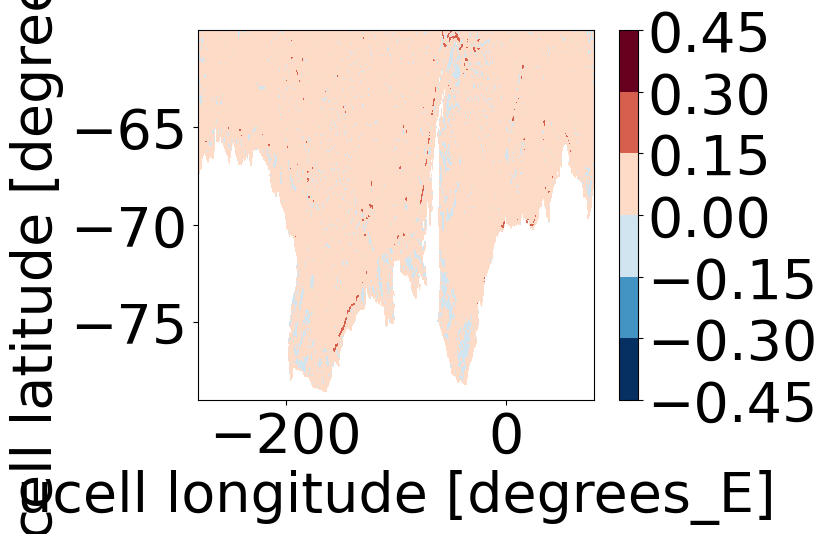

In [24]:
dhu_dy.plot.contourf()

In [29]:
# Calculate the magnitude of the topographic slope
slope = np.sqrt(dhu_dx**2 + dhu_dy**2).rename('slope')

In [30]:
slope

<xarray.DataArray 'slope' (yu_ocean: 440, xu_ocean: 3600)> Size: 6MB
dask.array<sqrt, shape=(440, 3600), dtype=float32, chunksize=(440, 900), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 4kB -78.98 -78.93 -78.89 ... -60.07 -60.02

In [35]:
#dhu_dy.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/dhu_dy_circfield.nc')
dhu_dx.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/dhu_dx_circfield.nc')
#slope.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/slope_circfield.nc')

TypeError: illegal data type for attribute b'periodic', must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got b1

In [45]:
hu_region = hu.sel( yu_ocean = lat_lim, xu_ocean = lon_lim)

In [46]:
## Along slope velocities

In [44]:
cluster_mask_access = xr.open_mfdataset('Antarctic-Eddy-Res-Compare/largest_3cluster_mask_xr_accessom201.nc')

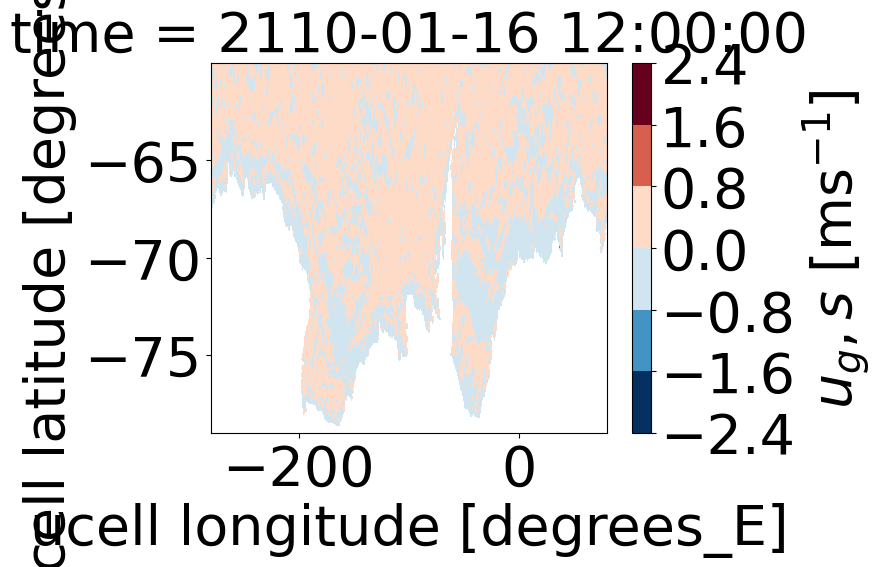

In [27]:
u.isel(time = 0).plot.contourf()

In [46]:
mask_shelf = xr.where(hu<1000 , True, False)
mask_slope = xr.where(hu>1000, True, False)

In [49]:
def calc_u_along_integral_mask_tt(tt, chunk_size, mask_region):
    u_t = u.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    v_t = v.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
    
    u_comp = (u_t*dhu_dy/slope).__xarray_dataarray_variable__#.compute()
    v_comp = (v_t*dhu_dx/slope).__xarray_dataarray_variable__#.compute()
    u_along = u_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50}) - v_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50})
    u_along_tt = grid.integrate(u_along, axis = {'X', 'Y'}).load()#.values
    print(tt)
    return u_along_tt

In [56]:
tt = 100
chunk_size = 1
mask_region = mask_shelf
u_t = u.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
v_t = v.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()

u_comp = (u_t*dhu_dy/slope).__xarray_dataarray_variable__#.compute()
v_comp = (v_t*dhu_dx/slope).__xarray_dataarray_variable__#.compute()
u_along = u_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50}) - v_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50})

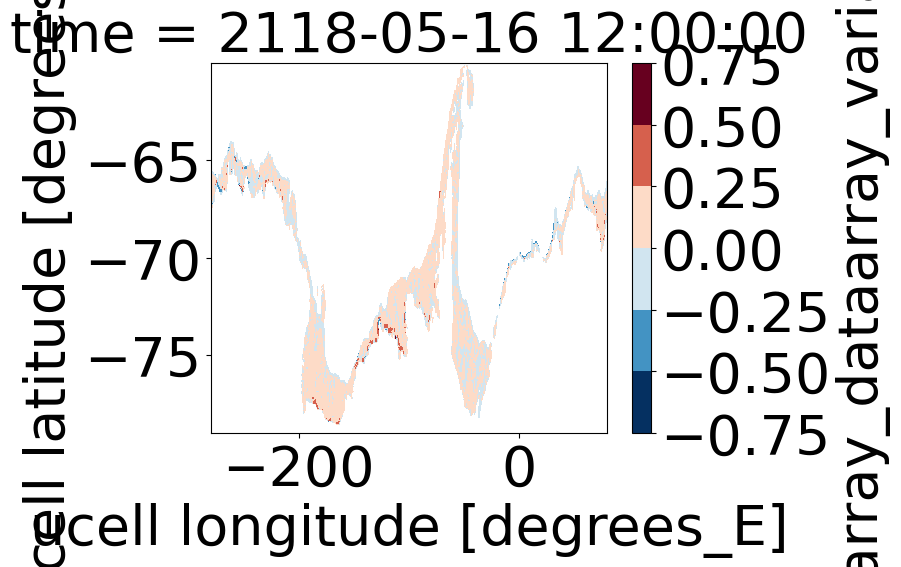

In [59]:
u_along.isel(time = 0).plot.contourf()

In [60]:
tt = 100
chunk_size = 1
mask_region = mask_slope
u_t = u.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()
v_t = v.isel(time = slice(tt*chunk_size, chunk_size*(tt+1))).where(cluster_mask_access == True).where(mask_region == True).load()

u_comp = (u_t*dhu_dy/slope).__xarray_dataarray_variable__#.compute()
v_comp = (v_t*dhu_dx/slope).__xarray_dataarray_variable__#.compute()
u_along = u_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50}) - v_comp.chunk({ 'yu_ocean':100, 'xu_ocean':50})

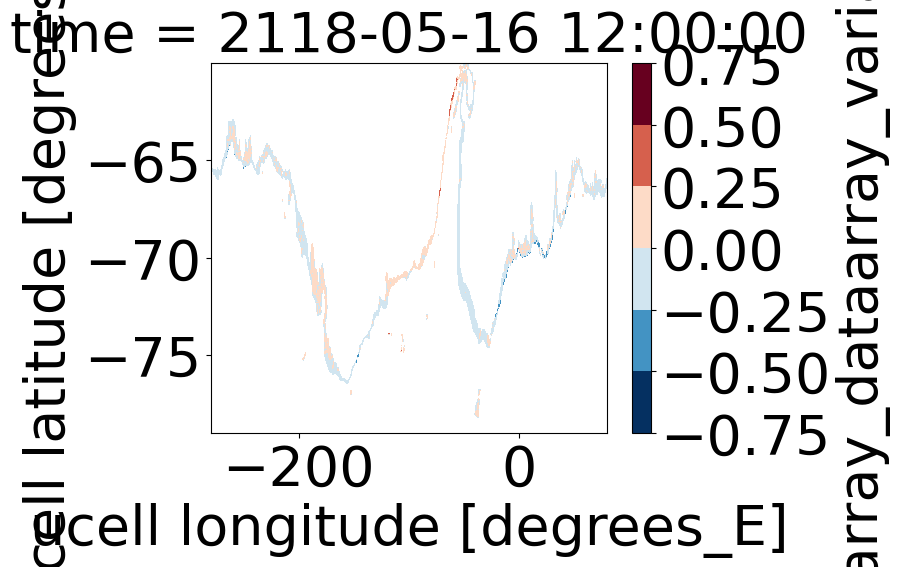

In [61]:
u_along.isel(time = 0).plot.contourf()

In [50]:
expt

'01deg_jra55v13_ryf9091'

In [51]:
u_along_exp_full = []

chunk_size = 100
for tt in range(int(600/chunk_size)):
    u_along_tt = calc_u_along_integral_mask_tt(tt, chunk_size, cluster_mask_access).rename('u_along')
    u_along_exp_full.append(u_along_tt)

0
1
2
3
4
5


In [52]:
U_ALONG = xr.merge(u_along_exp_full)#.plot()

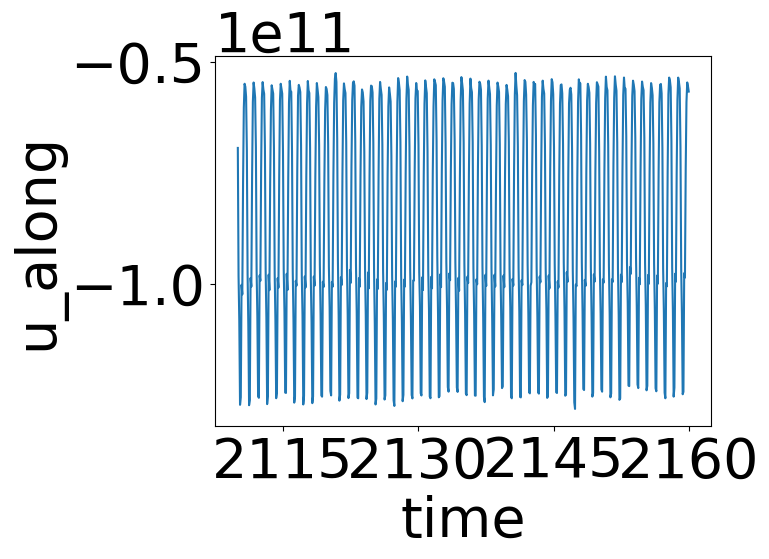

In [53]:
U_ALONG.u_along.plot()

In [54]:
U_ALONG.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + expt +'.nc')

In [57]:
u_along_exp_slope = []

chunk_size = 100
for tt in range(int(600/chunk_size)):
    u_along_tt = calc_u_along_integral_mask_tt(tt, chunk_size, mask_slope).rename('u_along')
    u_along_exp_slope.append(u_along_tt)
U_ALONG_SLOPE = xr.merge(u_along_exp_slope)#.plot()

0
1
2
3
4
5


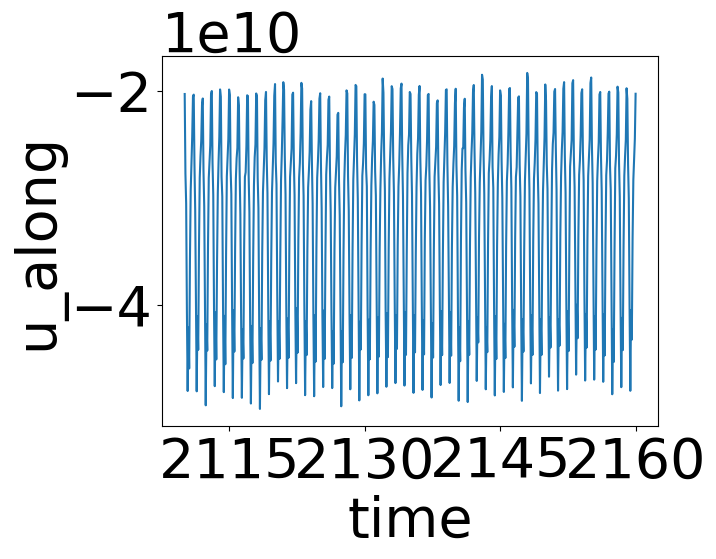

In [58]:
U_ALONG_SLOPE.u_along.plot()

In [59]:
U_ALONG_SLOPE.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + expt +'_slope.nc')

In [60]:
u_along_exp_shelf = []

chunk_size = 100
for tt in range(int(600/chunk_size)):
    u_along_tt = calc_u_along_integral_mask_tt(tt, chunk_size, mask_shelf).rename('u_along')
    u_along_exp_shelf.append(u_along_tt)
U_ALONG_SHELF = xr.merge(u_along_exp_shelf)#.plot()

0
1
2
3
4
5


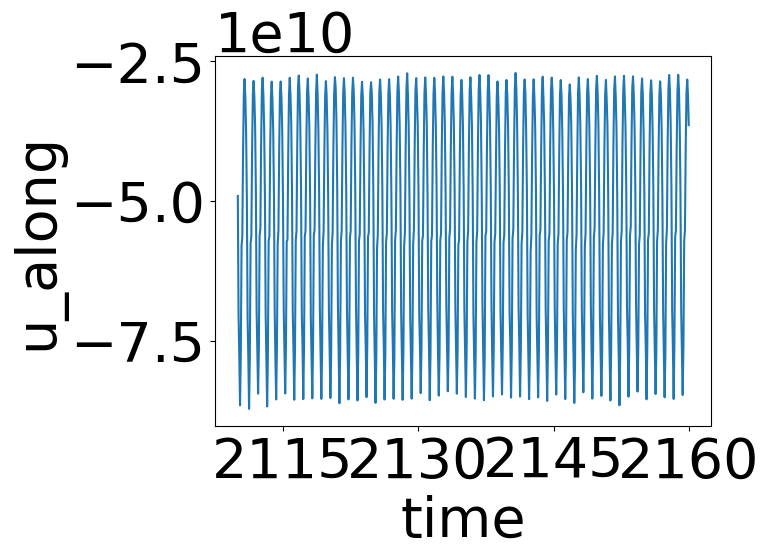

In [61]:
U_ALONG_SHELF.u_along.plot()

In [62]:
U_ALONG_SHELF.to_netcdf('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + expt +'_shelf.nc')

In [87]:
U_ALONG_SHELF_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthmp +'_shelf.nc')

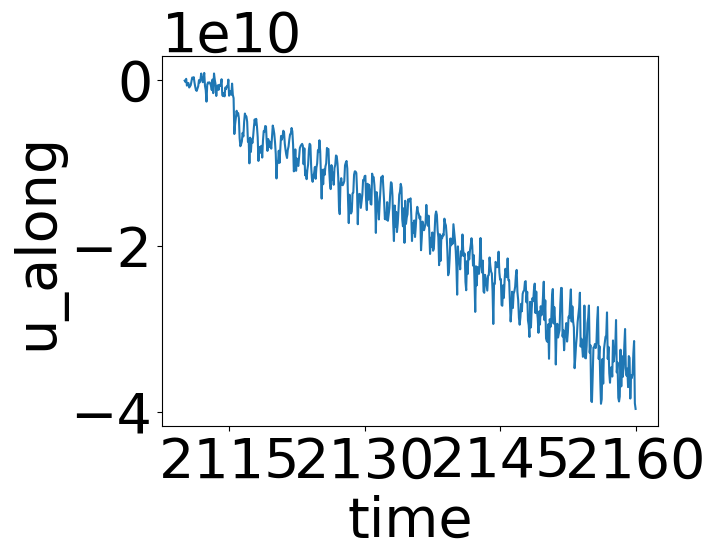

In [91]:
(U_ALONG_SHELF_wthmp - U_ALONG_SHELF).u_along.plot()

In [47]:
## plotting everything together

#calculating area on shelf and slope total
area_u = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_u', 
                          session=session, frequency='static',
                          attrs={'cell_methods': 'time: point'}, n=1).sel(xu_ocean= lon_lim, yu_ocean = lat_lim)
circ_area_slope = (area_u*cluster_mask_access.where(mask_slope ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
circ_area_shelf = (area_u*cluster_mask_access.where(mask_shelf ==True)).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           
circ_area_total = (area_u*cluster_mask_access).sum().__xarray_dataarray_variable__.values                                                                                                                                                                                           


In [38]:
def weighted_temporal_mean(ds):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds.u_along
    
    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [21]:

U_ALONG_SHELF_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthmp +'_shelf.nc')/circ_area_shelf
U_ALONG_SHELF_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthp +'_shelf.nc')/circ_area_shelf
U_ALONG_SHELF_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_ctrl +'_shelf.nc')/circ_area_shelf

U_ALONG_SLOPE_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthmp +'_slope.nc')/circ_area_slope
U_ALONG_SLOPE_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthp +'_slope.nc')/circ_area_slope
U_ALONG_SLOPE_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_ctrl +'_slope.nc')/circ_area_slope

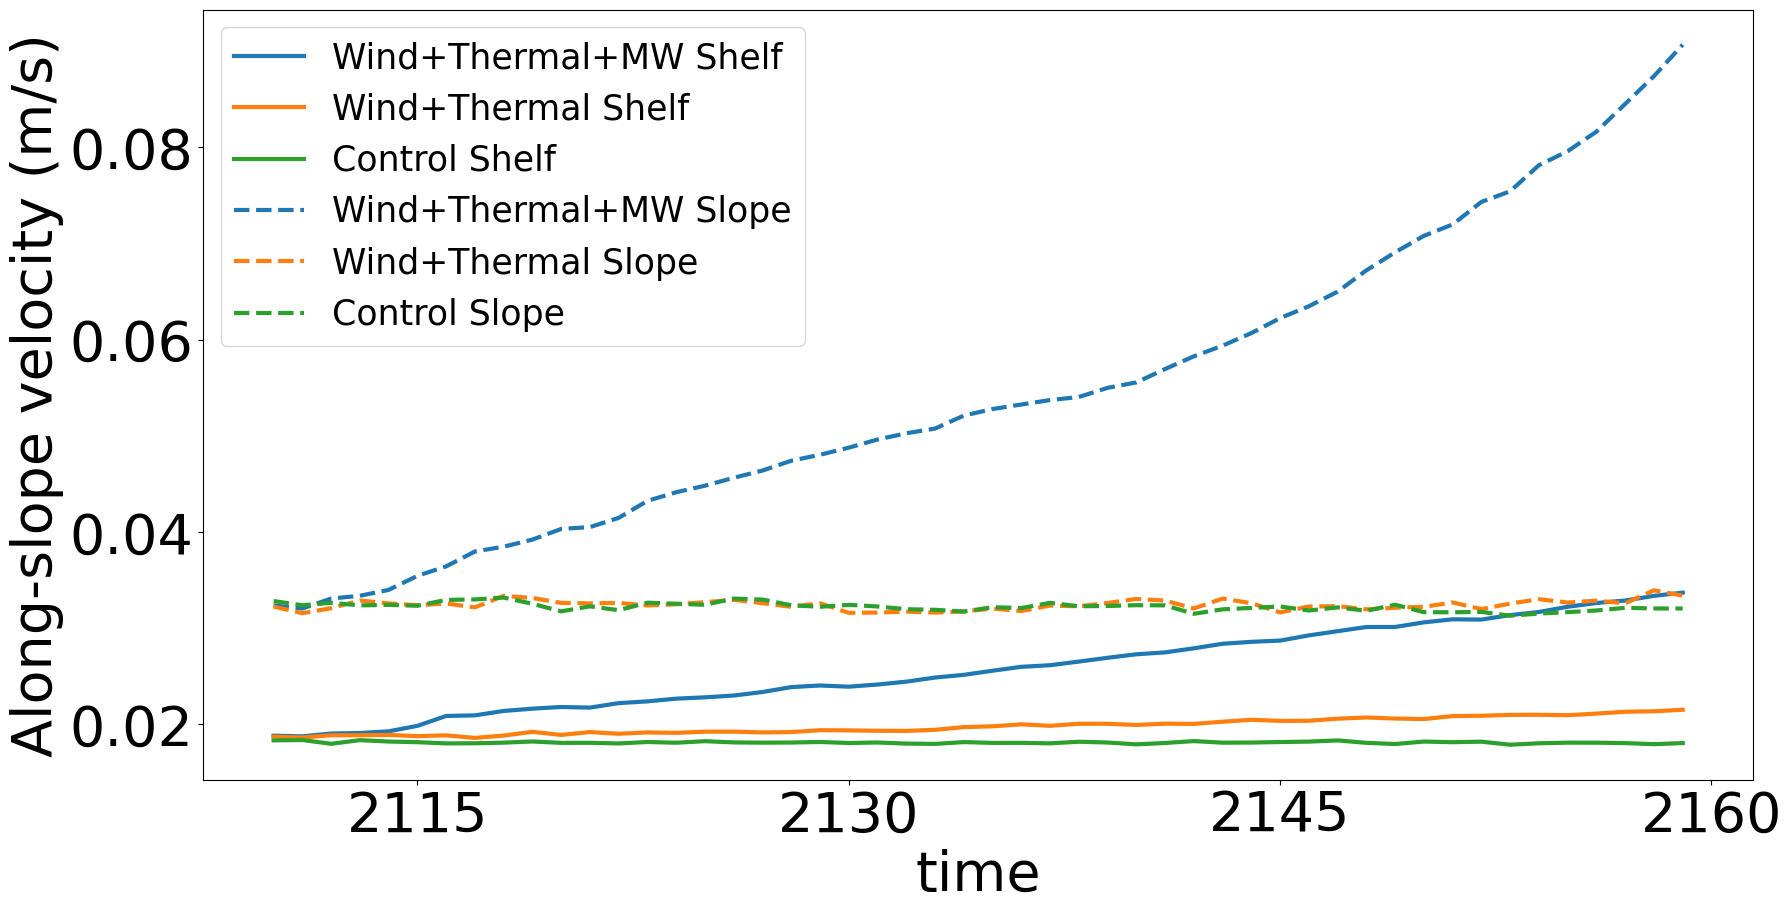

In [83]:
plt.figure(figsize = (20,10))
weighted_temporal_mean(-U_ALONG_SHELF_wthmp).plot( label = 'Wind+Thermal+MW Shelf', lw =3)
weighted_temporal_mean(-U_ALONG_SHELF_wthp).plot(label = 'Wind+Thermal Shelf', lw =3)
weighted_temporal_mean(-U_ALONG_SHELF_ctrl).plot(label = 'Control Shelf', lw =3)
weighted_temporal_mean(-U_ALONG_SLOPE_wthmp).plot( label = 'Wind+Thermal+MW Slope', linestyle = 'dashed', color = 'C0', lw =3)
weighted_temporal_mean(-U_ALONG_SLOPE_wthp).plot(label = 'Wind+Thermal Slope', linestyle = 'dashed', color = 'C1', lw =3)
weighted_temporal_mean(-U_ALONG_SLOPE_ctrl).plot(label = 'Control Slope', linestyle = 'dashed', color = 'C2', lw =3)

plt.ylabel('Along-slope velocity (m/s)')
plt.legend(fontsize = 25)
#plt.ylim([0,0.17])

In [22]:
## cumulative meltwater addition
MW_ant_final = 0.08 # [Sv], 0.160 sv/century added around west antarctica
m_MW_ant = 0.08/len(U_ALONG_SLOPE_wthmp.time)
y_MW_ant = m_MW_ant*np.arange(1,len(U_ALONG_SLOPE_wthmp.time)+1)
#y_MW_ant

In [23]:
np.cumsum(y_MW_ant)

array([1.33333333e-04, 4.00000000e-04, 8.00000000e-04, 1.33333333e-03,
       2.00000000e-03, 2.80000000e-03, 3.73333333e-03, 4.80000000e-03,
       6.00000000e-03, 7.33333333e-03, 8.80000000e-03, 1.04000000e-02,
       1.21333333e-02, 1.40000000e-02, 1.60000000e-02, 1.81333333e-02,
       2.04000000e-02, 2.28000000e-02, 2.53333333e-02, 2.80000000e-02,
       3.08000000e-02, 3.37333333e-02, 3.68000000e-02, 4.00000000e-02,
       4.33333333e-02, 4.68000000e-02, 5.04000000e-02, 5.41333333e-02,
       5.80000000e-02, 6.20000000e-02, 6.61333333e-02, 7.04000000e-02,
       7.48000000e-02, 7.93333333e-02, 8.40000000e-02, 8.88000000e-02,
       9.37333333e-02, 9.88000000e-02, 1.04000000e-01, 1.09333333e-01,
       1.14800000e-01, 1.20400000e-01, 1.26133333e-01, 1.32000000e-01,
       1.38000000e-01, 1.44133333e-01, 1.50400000e-01, 1.56800000e-01,
       1.63333333e-01, 1.70000000e-01, 1.76800000e-01, 1.83733333e-01,
       1.90800000e-01, 1.98000000e-01, 2.05333333e-01, 2.12800000e-01,
      

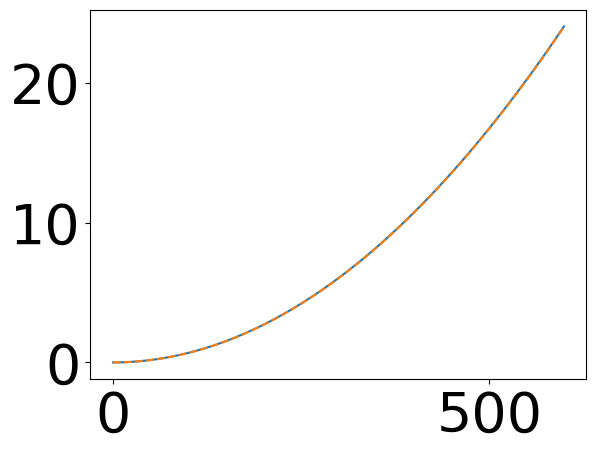

In [77]:
plt.plot(np.cumsum(y_MW_ant))
plt.plot(m_MW_ant * (np.arange(1,len(U_ALONG_SLOPE_wthmp.time)+1))**2 *0.5, linestyle = 'dashed')
# integrating over m_MW_ant * t where t is in number of days MW forcing is applied -- \int [Sv] dt = [Sv][days]

(-8.0, 25.0)

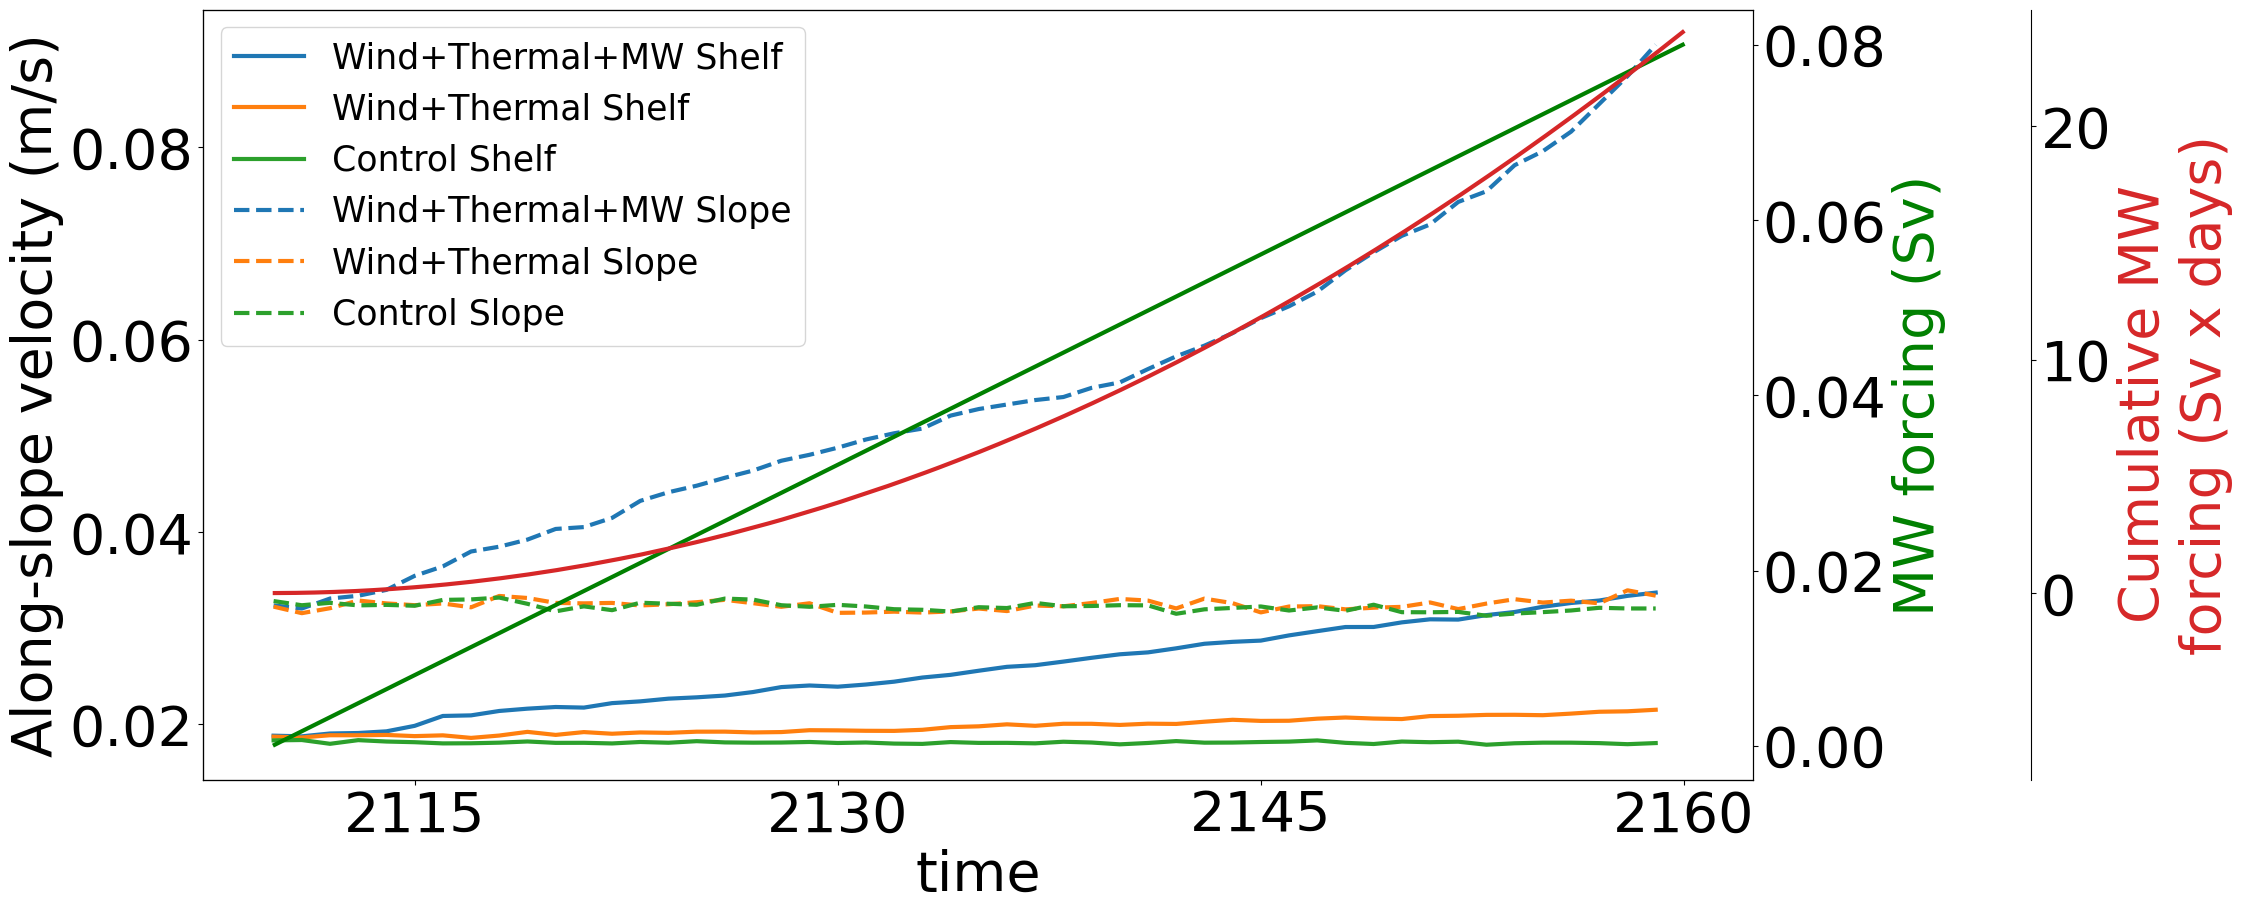

In [24]:
fig, ax = plt.subplots(figsize = (20,10))

weighted_temporal_mean(-U_ALONG_SHELF_wthmp).plot( label = 'Wind+Thermal+MW Shelf', lw =3)
weighted_temporal_mean(-U_ALONG_SHELF_wthp).plot(label = 'Wind+Thermal Shelf', lw =3)
weighted_temporal_mean(-U_ALONG_SHELF_ctrl).plot(label = 'Control Shelf', lw =3)
weighted_temporal_mean(-U_ALONG_SLOPE_wthmp).plot( label = 'Wind+Thermal+MW Slope', linestyle = 'dashed', color = 'C0', lw =3)
weighted_temporal_mean(-U_ALONG_SLOPE_wthp).plot(label = 'Wind+Thermal Slope', linestyle = 'dashed', color = 'C1', lw =3)
weighted_temporal_mean(-U_ALONG_SLOPE_ctrl).plot(label = 'Control Slope', linestyle = 'dashed', color = 'C2', lw =3)

plt.ylabel('Along-slope velocity (m/s)')
plt.legend(fontsize = 25)
#plt.ylim([0,0.17])

ax2 = ax.twinx()
ax2.plot(U_ALONG_SLOPE_wthmp.time, y_MW_ant, label = 'MW forcing (Sv)', color = 'g', lw = 3)
ax2.set_ylabel('MW forcing (Sv)',color = 'g')

ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 200))
ax3.plot(U_ALONG_SLOPE_wthmp.time, np.cumsum(y_MW_ant), label = 'Cumulative MW forcing (Sv)', color = 'C3', lw = 3)
ax3.set_ylabel('Cumulative MW \nforcing (Sv x days)',color = 'C3')
ax3.set_ylim([-8,25])


In [49]:

U_ALONG_wthmp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthmp +'.nc')/circ_area_total
U_ALONG_wthp = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_wthp +'.nc')/circ_area_total
U_ALONG_ctrl = xr.open_mfdataset('/g/data/v45/qo9901/MW-perturb-ASC-data/ualong_monthly_tt_' + exp_ctrl +'.nc')/circ_area_total


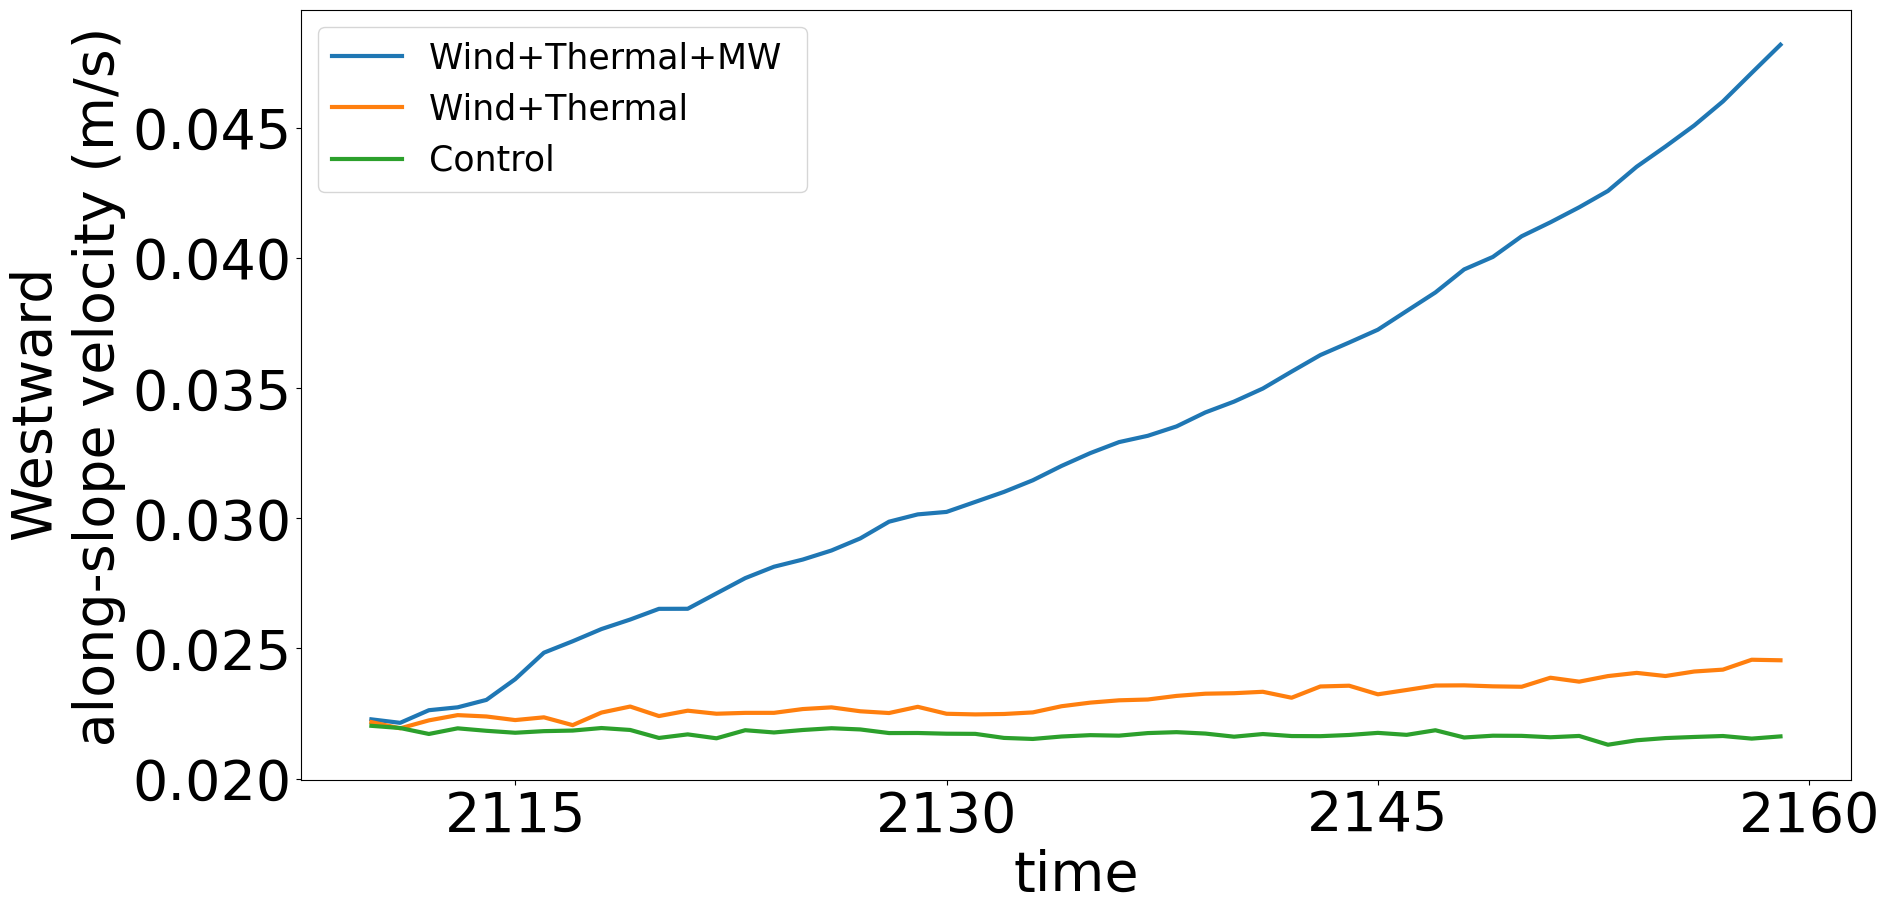

In [51]:
plt.figure(figsize = (20,10))
weighted_temporal_mean(-U_ALONG_wthmp).plot( label = 'Wind+Thermal+MW ', lw =3)
weighted_temporal_mean(-U_ALONG_wthp).plot(label = 'Wind+Thermal ', lw =3)
weighted_temporal_mean(-U_ALONG_ctrl).plot(label = 'Control', lw =3)

plt.ylabel('Westward \n along-slope velocity (m/s)')
plt.legend(fontsize = 25)
#plt.ylim([0,0.17])